<a href="https://colab.research.google.com/github/tanaxer01/DHA1001_Transito/blob/main/index_calcs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [255]:
!if [ ! -d mov-in-covid ]; then \
  git clone https://github.com/tanaxer01/mov-in-covid; \
  mv mov-in-covid/*.py .; fi

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy  as np
import utils

In [3]:
datasets = {
  # DP1
  "dp1_contagios": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto1/Covid-19_std.csv",
  # DP51
  "dp51_difs": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto51/ISCI_std.csv",
  # DP82
  "dp82_weeks": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto82/ISCI_weeks.csv",
  "dp82_weekends": "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto82/ISCI_weekends.csv",
  # DP...
}

for name, url in datasets.items():
  utils.get_file(name, url)

[+] created ./datos/
[+] downloaded ./datos/dp1_contagios
[+] downloaded ./datos/dp51_difs
[+] downloaded ./datos/dp82_weeks
[+] downloaded ./datos/dp82_weekends


# DATASET PREP

# DP1

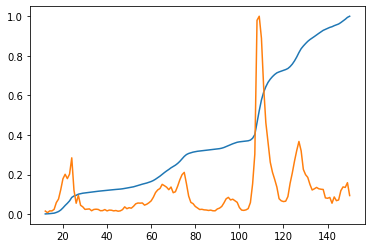

In [308]:
DataProduct1 = pd.read_csv("./datos/dp1_contagios.csv", parse_dates=["Fecha"])

# Just RM
DataProduct1 = DataProduct1[ DataProduct1["Codigo region"] == 13 ].drop(columns=["Region", "Codigo region"])
DataProduct1 = DataProduct1.set_index("Fecha")

# Week num
DataProduct1["Semana"] = (DataProduct1.index.to_series() - datetime.strptime("2020-01-01", "%Y-%m-%d")).dt.days // 7

# Drop `Desconocido Metropolitana`
DataProduct1 = DataProduct1[ DataProduct1.Comuna != "Desconocido Metropolitana" ]

casos = pd.DataFrame({ i:DataProduct1[ DataProduct1.Comuna == i ].groupby("Semana")["Casos confirmados"].mean() for i in set(DataProduct1.Comuna) }) 
casos_nuevos = casos.subtract( casos.shift(periods=1, fill_value=0) )

#casos_old = DataProduct1.pivot_table(values="Casos confirmados", index="Fecha", columns="Comuna")
#casos_oldnuevos = casos.subtract( casos.shift(periods=1, fill_value=0) )

DataProduct1.head(2)

plt.figure()
plt.plot(casos["Santiago"] / casos["Santiago"].max())
plt.plot(casos_nuevos["Santiago"] / casos_nuevos["Santiago"].max())

plt.show()

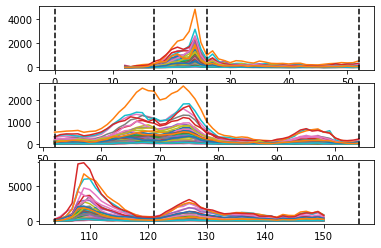

In [303]:
date2week = lambda x: (datetime.strptime(x, "%Y-%m-%d") - datetime.strptime("2020-01-01", "%Y-%m-%d")).days // 7

plt.subplot(3,1,1)
plt.plot( casos_nuevos.loc[:date2week("2021-01-01")] )

for i in ["2020-01-01", "2020-05-01", "2020-07-01", "2020-12-31"]:
  plt.axvline(x=date2week(i), color='black', linestyle='--')

plt.subplot(3,1,2)
plt.plot( casos_nuevos.loc[date2week("2021-01-01"):date2week("2022-01-01")] )

for i in ["2021-01-01", "2021-05-01", "2021-07-01", "2021-12-31"]:
  plt.axvline(x=date2week(i), color='black', linestyle='--')

plt.subplot(3,1,3)
plt.plot( casos_nuevos.loc[date2week("2022-01-01"):] )

for i in ["2022-01-01", "2022-05-01", "2022-07-01", "2022-12-31"]:
  plt.axvline(x=date2week(i), color='black', linestyle='--')

plt.show()

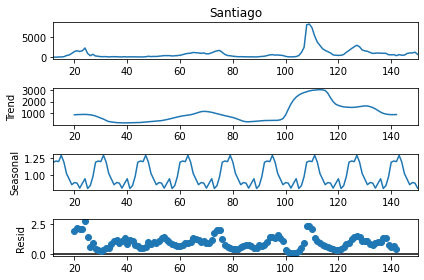

In [312]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(casos_nuevos["Santiago"], period=16, model="multiplicative").plot()

## DP51
link: [product51](https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto51)


In [276]:
df_difs = pd.read_csv("./datos/dp51_difs.csv")

# Fecha to Datetime && sort by Fecha
df_difs['Fecha'] = pd.to_datetime(df_difs['Fecha'])
df_difs = df_difs.sort_values(by=['Fecha'])

# Just RM
df_difs = df_difs[ df_difs['Codigo region'] == 13 ].drop(columns=['Region', 'Codigo region'])

# Calc prom of Dif salida y Dif entrada.
def parse_diff(x):
  mean = sum([ int(i)  for i in x[1:-2].replace('%','').split(",") ])/2
  
  return (100 + mean)/100

df_difs['Salida'] = df_difs['Dif salida'].map(parse_diff)
df_difs['Entrada'] = df_difs['Dif entrada'].map(parse_diff)

df_salidas  = pd.DataFrame({ i:df_difs[ df_difs["Comuna"] == i ].groupby("Fecha")["Salida"].mean() for i in set(df_difs["Comuna"]) })
df_entradas = pd.DataFrame({ i:df_difs[ df_difs["Comuna"] == i ].groupby("Fecha")["Entrada"].mean() for i in set(df_difs["Comuna"]) })

df_difs.head(1)

,Comuna,Codigo comuna,Cartodb id,Zona censal,Week,Dif salida,Dif entrada,Fecha,Salida,Entrada
458790,Peñalolén,13122,501401,13122011003,9,"[-21%,+20%,]","[-21%,+20%,]",2020-03-02,0.995,0.995


In [279]:
df_difs[ df_difs["Week"] == df_difs["Week"].max() ]

,Comuna,Codigo comuna,Cartodb id,Zona censal,Week,Dif salida,Dif entrada,Fecha,Salida,Entrada
500369,Calera de Tango,13403,491830,13403021002,121,"[-21%,+20%,]","[-21%,+20%,]",2022-04-25,0.995,0.995
40006,Santiago,13101,321990,13101081003,121,"[+21%,+40%,]","[+61%,+100%,]",2022-04-25,1.305,1.805
40776,Santiago,13101,334420,13101211001,121,"[-21%,+20%,]","[-40%,-21%,]",2022-04-25,0.995,0.695
39896,Santiago,13101,321880,13101081002,121,"[-21%,+20%,]","[+41%,+60%,]",2022-04-25,0.995,1.505
499929,Calera de Tango,13403,406140,13403011001,121,"[-21%,+20%,]","[+61%,+100%,]",2022-04-25,0.995,1.805
...,...,...,...,...,...,...,...,...,...,...
382669,Estación Central,13106,444420,13106101004,121,"[-21%,+20%,]","[-21%,+20%,]",2022-04-25,0.995,0.995
383109,Estación Central,13106,466200,13106081002,121,"[-21%,+20%,]","[+61%,+100%,]",2022-04-25,0.995,1.805
477709,San Miguel,13130,365000,13130061002,121,"[-21%,+20%,]","[-21%,+20%,]",2022-04-25,0.995,0.995
383219,Estación Central,13106,466310,13106081003,121,"[-21%,+20%,]","[+21%,+40%,]",2022-04-25,0.995,1.305


## DP82
link: [product82](https://github.com/MinCiencia/Datos-COVID19/tree/master/output/producto82)

In [ ]:
df_weeks = pd.read_csv('./datos/dp82_weeks.csv')
#df_weekends = pd.read_csv('./datos/dp82_weekends.csv')

# Fecha to Datetime && sort by Fecha
df_weeks['fecha_inicio'] = pd.to_datetime(df_weeks['fecha_inicio'])
df_weeks = df_weeks.sort_values(by=['fecha_inicio'])

# Just RM
df_weeks = df_weeks[ df_weeks['region'] == 13 ].drop(columns=['region'])

# Just dates on DP51
df_weeks = df_weeks[ df_weeks["fecha_inicio"].isin(df_difs["Fecha"]) ]

# [!] Fill pasos 
df_weeks["paso"] = df_weeks["paso"].fillna(method="ffill")

# DF pasos
df_pasos = df_weeks.pivot_table(values='paso', index='fecha_inicio', columns='nom_comuna')

df_weeks.head(1)

,semana,paso,nom_comuna,comuna,fecha_inicio,fecha_termino,var_salidas,var_salidas_cota_inferior,var_salidas_cota_superior
11544,9,0.0,PUDAHUEL,13124,2020-03-02,2020-03-06,0.988342,0.985605,0.99108


## `Dif salida` VS `var_salidas`
En general siguen las mismas tendencias, pero tienen una diferencia de 0.2 que no estoy seguro pq ocurre.
Lo unico raro es la diferencia al final, (el peak hacia abajo es por un error de mediciones en uno de los datasets.) pero al final, el dataset `var` tiene un amuento raro que no se ve en la otra curva.

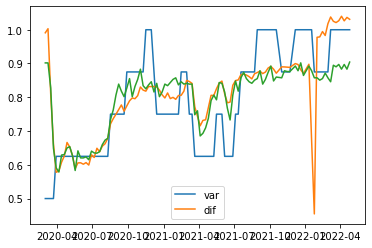

'shift promedio entre var y dif: 0.19000725738526164'

In [ ]:
dif  = df_salidas["Santiago"]
var  = df_weeks[ df_weeks["nom_comuna"] == "SANTIAGO" ].set_index("fecha_inicio")

var_salidas = var["var_salidas"]
paso = var["paso"]

plt.figure()

plt.plot(paso / 8 + 0.5)
plt.plot(var_salidas)
plt.plot(dif - 0.2)

plt.legend(["var", "dif"])
plt.show()

f"shift promedio entre var y dif: {(dif - var_salidas).mean()}"

# Medición de eficiencia